In [440]:
import numpy as np
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import cvxpy
from cvxpy import *
from sklearn.preprocessing import Normalizer 
from copy import deepcopy

In [441]:
# plt.style.use('default')
plt.rcParams.update({'font.size':18})
# plt.rcParams.update({'text.usetex' : True})
figDir = '/Users/aqib/Desktop/UCSB/research/BCCL/structured-dmd/NSBA_submission/figures/'
my_cmap = sns.diverging_palette(15, 221, s=99, sep=1, l=45, center='light',as_cmap=True)
# sns.choose_diverging_palette()

#### Import and wrangle NAND data

In [442]:
JU_frame = pd.read_csv('NAND_Chassis_RNAseq_preCAD_TPM.tsv',sep='\t')                    
all_column_names = JU_frame.columns

# gingko sample ids are currently column headers
# removing the ginkgo preamble of each header here
new_column_names = [None]*len(all_column_names)
new_column_names[0] = all_column_names[0]
for col_ind in range(1,len(all_column_names)):
    column_name = str(all_column_names[col_ind])
    this_id = column_name.split('.')[-1]
    new_column_names[col_ind] = this_id
clear_JU_frame = pd.DataFrame(JU_frame)
clear_JU_frame.columns=new_column_names # clear_JU_frame is the dataframe used for BioCAS
# get gene names
all_genes = clear_JU_frame['gene_id']

# strain to sample id mapping and sample id to condition mapping
dict_list = pickle.load(open('dict_files.pickle','rb'))
strain_to_ids_dict = dict_list[0]
cond_dict = dict_list[1] # each list is as follows: [ara_conc, iptg_conc, temp, time, replicate]

In [443]:
# thankfully the strain to id mapping and cond to id mapping that Enoch did still holds for raw counts df
# however note that the genes are not listed in the same row order as clear_JU_frame and does not contain
# extraneous circuit components
# another question, why does the strain_to_ids mapping have duplicates? 
# what are fecA and rsd? not in genome annotation files, maybe we should remove these
df_cts = pd.read_csv('data/Reordered_ReadCountMatrix_preCAD.csv',low_memory=False,) # comes with 13 circuit genes
df_cts.columns = df_cts.iloc[0,:] # 
df_cts.rename(columns={'GinkgoID': 'gene_id'}, inplace=True)
# drop fecA and rsd 
fecA_ind, rsd_ind = list(df_cts['gene_id']).index('fecA'), list(df_cts['gene_id']).index('rsd') 
df_cts = df_cts.drop([fecA_ind, rsd_ind])
df_cts = (df_cts.iloc[12:]).reset_index(drop=True)

df_tpm = pd.read_csv('data/Reordered_ReadCountMatrix_preCAD_TPM.csv',low_memory=False,)
df_tpm.columns = df_tpm.iloc[0,:]
df_tpm.rename(columns={'GinkgoID': 'gene_id'}, inplace=True)
# drop fecA and rsd 
fecA_ind, rsd_ind = list(df_tpm['gene_id']).index('fecA'), list(df_tpm['gene_id']).index('rsd') 
df_tpm = df_tpm.drop([fecA_ind, rsd_ind])
df_tpm = (df_tpm.iloc[12:]).reset_index(drop=True)

In [444]:
df_cts.iloc[:,1:] = df_cts.iloc[:,1:].astype(int)
df_tpm.iloc[:,1:] = df_tpm.iloc[:,1:].astype(float)

In [445]:
def gen_master_dict(df):
    
    # create nested dictionary to get expression data from strain key and cond key
    master_dict = {}
    for this_strain_id in strain_to_ids_dict.keys():
        # get sample id for this_strain
        ids = list(set(strain_to_ids_dict[this_strain_id]))
        
        # get condition corresponding to sample id
        data_by_cond_dict = {}
        for this_id in ids:
            # get experimental condition and parse
            cond_num = cond_dict[this_id]
            if cond_num[0] > 0.0: # only two ara and iptg levels
                ara_state = '1'
            else:
                ara_state = '0'
            if cond_num[1] > 0.0:
                iptg_state = '1'
            else:
                iptg_state = '0'

            temperature = repr(int(cond_num[2]))
            timepoint = repr(int(cond_num[3]))
            replicate_num = repr(int(cond_num[4]))

            cond_key = ara_state + iptg_state + temperature + timepoint + replicate_num
            if this_id in df.columns:
                # get expression snapshot for sample
                data_for_condition = df[this_id].values

                if this_strain_id in master_dict.keys():
                    if cond_key in master_dict[this_strain_id].keys():
                        master_dict[this_strain_id][cond_key].append(data_for_condition)    
                    else:    
                        master_dict[this_strain_id][cond_key] = [data_for_condition]

                else:
                    master_dict[this_strain_id] = dict(); 
                    if cond_key in master_dict[this_strain_id].keys():
                        master_dict[this_strain_id][cond_key].append(data_for_condition)    
                    else:    
                        master_dict[this_strain_id][cond_key] = [data_for_condition]
    return master_dict

In [446]:
master_dict = gen_master_dict(df_cts)

In [447]:
# make a dataframe that lays out the conditions for each strain
colnames = ['strain','cond_id','ara','iptg','temp','time','rep']
df_cond = pd.DataFrame(np.zeros((352,7)))
df_cond.columns = colnames
cnt = 0
for strain in master_dict.keys():
    for cond in master_dict[strain].keys():
        df_cond.iloc[cnt,0] = strain # set strain 
        df_cond.iloc[cnt,1] = cond # set cond_id
        df_cond.iloc[cnt,2] = int(cond[0]) # set ara conc
        df_cond.iloc[cnt,3] = int(cond[1]) # set iptg_conc
        df_cond.iloc[cnt,4] = int(cond[2:4]) # set temp
        if len(cond) == 6: # set time
            df_cond.iloc[cnt,5] = int(cond[4])
        else: 
            df_cond.iloc[cnt,5] = int(cond[4:6])
        df_cond.iloc[cnt,6] = int(cond[-1])
        cnt += 1
# converting from float to int
df_cond = df_cond.astype({'ara':'int','iptg':'int','temp':'int','time':'int','rep':'int'}) 

<ipython-input-448-6aff73a92f1e>:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


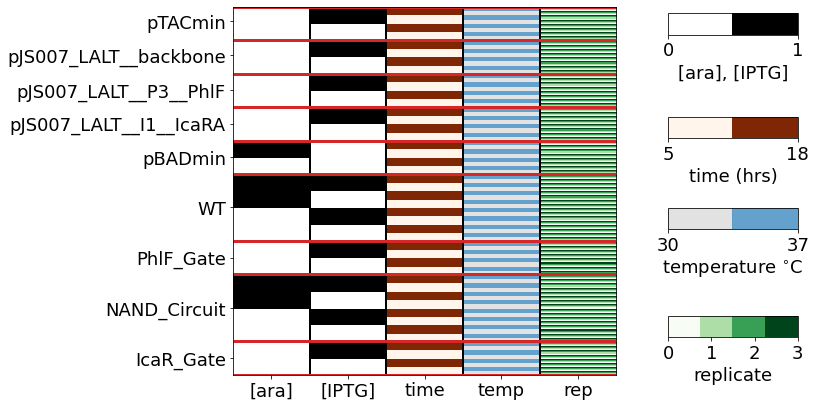

In [448]:
df_cond_sort = df_cond.sort_values(['strain','ara','iptg','time','temp','rep'])

fig, ax = plt.subplots(figsize=(9,6))
N = len(df_cond)

cmap = matplotlib.cm.get_cmap('binary', 2)
im1 = ax.imshow(np.array(df_cond_sort['ara'])[:,np.newaxis],aspect='auto',extent=[0,2,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')
im2 = ax.imshow(np.array(df_cond_sort['iptg'])[:,np.newaxis],aspect='auto',extent=[2,4,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')
cmap = matplotlib.cm.get_cmap('Oranges',2)
im3 = ax.imshow(np.array(df_cond_sort['time'])[:,np.newaxis],aspect='auto',extent=[4,6,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')
cmap = matplotlib.cm.get_cmap('tab20c_r',2)
im4 = ax.imshow(np.array(df_cond_sort['temp'])[:,np.newaxis],aspect='auto',extent=[6,8,-0.5,N-0.5],origin='lower',cmap=cmap,alpha=0.75,interpolation='none')
cmap = matplotlib.cm.get_cmap('Greens',4)
im5 = ax.imshow(np.array(df_cond_sort['rep'])[:,np.newaxis],aspect='auto',extent=[8,10,-0.5,N-0.5],origin='lower',cmap=cmap,interpolation='none')

cbax = fig.add_axes([1.05, 0.89, 0.2, 0.05]) # left, bottom, width, height
cbar1 = fig.colorbar(im1, cax=cbax, label='[ara], [IPTG]',fraction=0.027,orientation='horizontal',ticks=[0,1])
cbax = fig.add_axes([1.05, 0.65, 0.2, 0.05]) # left, bottom, width, height
cbar3 = fig.colorbar(im3, cax=cbax, label='time (hrs)',fraction=0.041,orientation='horizontal',ticks=[5,18])
cbax = fig.add_axes([1.05, 0.44, 0.2, 0.05]) # left, bottom, width, height
cbar4 = fig.colorbar(im4, cax=cbax, label=r'temperature $^{\circ}$C',fraction=0.033,orientation='horizontal',ticks=[30,37])
cbax = fig.add_axes([1.05, 0.19, 0.2, 0.05]) # left, bottom, width, height
cbar5 = fig.colorbar(im5, cax=cbax, label='replicate',fraction=0.05,orientation='horizontal',ticks=[0,1,2,3],panchor=(2,2))

ax.set_xlim(0,10)
ax.set_ylim(0,N)
ax.set_xticks([1,3,5,7,9])
ax.set_xticklabels(['[ara]','[IPTG]','time','temp','rep'])
yticks = [16,64,112,160,208,240,272,306,338]
# yticks = [0,16,32,64,96,112,128,160,192,208,224,240,256,272,290,306,322,338,352]
ax.set_yticks(yticks[::-1])
mult = 32
# ax.set_yticklabels([mult*'-','pTACmin',mult*'-',
#                     'MG1655_pJS007_LALT__backbone',mult*'-',
#                     'pJS007_LALT__P3__PhlF',mult*'-',
#                     'pJS007_LALT__I1__IcaRA',mult*'-',
#                     'pBADmin',mult*'-',
#                     'WT',mult*'-',
#                     'PhlF_Gate',mult*'-',
#                     'NAND_Circuit',mult*'-',
#                     'IcaR_Gate',mult*'-'])
ax.set_yticklabels(['pTACmin',
                    'pJS007_LALT__backbone',
                    'pJS007_LALT__P3__PhlF',
                    'pJS007_LALT__I1__IcaRA',
                    'pBADmin',
                    'WT',
                    'PhlF_Gate',
                    'NAND_Circuit',
                    'IcaR_Gate'])

lines = [2,4,6,8]
for x in lines: 
    ax.vlines(x,0,N,color='black',linewidth=2)

lines = [0,32,96,128,128+64,128+64+32,128+64+2*(32),128+64+3*(32),128+64+4*(32),128+64+5*(32)]
for y in lines: 
    ax.hlines(y,0,10,color='tab:red',linewidth=3)

plt.tight_layout()
# plt.savefig(figDir+'strain_condition_heatmap.pdf',bbox_inches='tight',dpi=300,transparent=True)
plt.show()

- The point of this heatmap is to show all the conditions that are essentially unused in our analysis and to highlight some strains are missing inducer conditions

#### Gene lengths from annotated reference
- Reorder the genes to be in same order as df_cts

In [449]:
gene_lengths = pd.read_csv('data/MG1655_Genomic_NAND_Circuit_gene_lengths.csv',usecols=['Name','Length'])
# split the gene name to get rid of 'gene=' substring
for ii,this_gene in enumerate(gene_lengths['Name']):
    gene_lengths['Name'][ii] = (this_gene.split('='))[1]
    
# put genes in gene_lengths in order of df_cts
reorder_gene_lengths = []
for ii,orig_gene in enumerate(df_cts['gene_id']):
    reorder_gene_lengths.append(list(gene_lengths['Name']).index(orig_gene))

gene_lengths = gene_lengths.loc[reorder_gene_lengths].reset_index(drop=True)
# we lost some annotated not needed lengths. specifically there were some terminators, promoters, etc. 

<ipython-input-449-6464cc6279c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_lengths['Name'][ii] = (this_gene.split('='))[1]


#### Pre-filtering and metadata
- Remove genes that have less than nSamples//2 reads total 
- Remove datapoints which have very few reads
- create a metadata table for DESeq2 analysis

In [450]:
# pre-filtering
nSamples = df_cts.shape[1]-1
df_cts_filter = (df_cts.loc[np.sum(df_cts.iloc[:,1:],axis=1) >= (nSamples//2)]).reset_index(drop=True)
gene_lengths_filter = gene_lengths.loc[np.sum(df_cts.iloc[:,1:],axis=1) >= (nSamples//2)].reset_index(drop=True)
df_tpm_filter = df_tpm.loc[np.sum(df_cts.iloc[:,1:],axis=1) >= (nSamples//2)].reset_index(drop=True)

# metadata (colData)
strain_abbrvs = {'MG1655_IcaR_Gate':'icar','MG1655_PhlF_Gate':'phlf',
                'MG1655_NAND_Circuit':'nand','MG1655_WT':'wt',
                'MG1655_pTACmin':'TAC','MG1655_pBADmin':'BAD',
                'MG1655_pJS007_LALT__P3__PhlF':'pJS007phlf',
                'MG1655_pJS007_LALT__I1__IcaRA':'pJS007icar',
                'MG1655_pJS007_LALT__backbone':'pJS007bb'}
colData = {'sample':[],'strain':[],'condition':[],'replicate':[],'temperature':[],
            'timepoint':[],'ara (M)':[],'iptg (M)':[],'orig_id':[]}
for sample_id in df_cts_filter.columns[1:]: # gingko sample_ids need to be mapped to strain and datapoint
    for strain in strain_to_ids_dict: # the sample_id can only be in one strain
        if sample_id in strain_to_ids_dict[strain]: # checking if this strain 
            colData['orig_id'].append(sample_id)
            colData['strain'].append(strain)
            # abbreviate strain to append to condition and sample name
            strain_abbrv = strain_abbrvs[strain]
    # now grab the condition information
    cond_num = cond_dict[sample_id]
    is_ara = '1' if (cond_num[0] > 0.0) else '0' 
    is_iptg = '1' if (cond_num[1] > 0.0) else '0' 
    temp = str(int(cond_num[2]))
    tp = str(int(cond_num[3]))
    rep = str(int(cond_num[4]))
    colData['condition'].append(strain_abbrv+'_'+is_ara+is_iptg+temp+tp) # this column exists solely to make life easy when comparing conditions in DESeq2, otherwise I would never put together such monstrosity hehe
    colData['sample'].append(strain_abbrv+'_'+is_ara+is_iptg+temp+tp+'R'+rep)
    colData['temperature'].append(temp)
    colData['timepoint'].append(tp)
    colData['ara (M)'].append(cond_num[0])
    colData['iptg (M)'].append(cond_num[1])
    colData['replicate'].append(rep)

df_cts_filter.columns = ['gene'] + colData['sample']
df_tpm_filter.columns = ['gene'] + colData['sample']
colData = pd.DataFrame(colData).sort_values(['strain','condition'])

# need to sort df_cts_filters columns so they are in same order as colData
# can use the index (+1 since we have 'gene' as first col in df) from colData
sorted_inds = [0] + [this_ind + 1 for this_ind in list(colData.index) ]
df_cts_filter = df_cts_filter.iloc[:,sorted_inds]
df_tpm_filter = df_tpm_filter.iloc[:,sorted_inds]

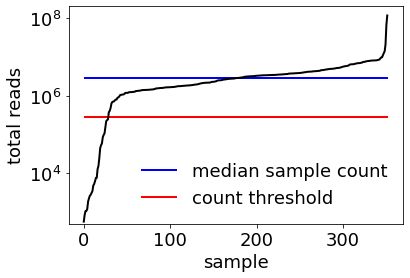

In [12]:
# which samples didn't get many reads mapped to them
sample_read_cts = {}
for sample in df_cts_filter.columns[1:]:
    sample_read_cts[sample] = np.sum(df_cts_filter[sample])
read_med_thresh = np.median(list(sample_read_cts.values())) * .1

# visualize the reads for samples
plt.figure()
plt.plot(np.sort(list(sample_read_cts.values())),lw=2,c='k')
plt.hlines(np.median(list(sample_read_cts.values())),0,len(sample_read_cts),color='blue',lw=2,
           label='median sample count')
plt.hlines(read_med_thresh,0,len(sample_read_cts),color='red',lw=2,
           label='count threshold')
plt.yscale('log')
plt.legend(frameon=False)
plt.xlabel('sample')
plt.ylabel('total reads')
plt.ylim(5e2,2e8)

plt.show()

In [13]:
high_seq_depth_samples = {}
low_seq_depth_samples = {}
high_seq_depth_mask = []
for sample,read_cnt in zip(sample_read_cts.keys(),sample_read_cts.values()):
    if read_cnt < read_med_thresh:
        low_seq_depth_samples[sample] = read_cnt
        high_seq_depth_mask.append(False)
    else: 
        high_seq_depth_samples[sample] = read_cnt
        high_seq_depth_mask.append(True)
        
# keep only the high_seq_depth_samples
keep_samples = ['gene'] + list(high_seq_depth_samples.keys()) # hang on the gene column
df_cts_filter = df_cts_filter[keep_samples]
colData = colData.iloc[high_seq_depth_mask].reset_index(drop=True)
df_tpm_filter = df_tpm_filter[keep_samples]

In [14]:
print('Samples with low sequencing depth:')
print(pd.DataFrame(list(low_seq_depth_samples.keys())))

Samples with low sequencing depth:
                      0
0          icar_00375R1
1          icar_01375R0
2         nand_013718R1
3          nand_01375R1
4          nand_10375R2
5          nand_10375R3
6          nand_11305R3
7          phlf_01305R1
8         phlf_013718R1
9          phlf_01375R1
10           wt_01305R1
11          wt_113718R1
12           wt_11375R1
13          BAD_00305R1
14          BAD_10305R0
15          BAD_10305R1
16          BAD_10305R2
17         BAD_103718R1
18          BAD_10375R1
19   pJS007icar_01305R0
20   pJS007icar_01305R1
21   pJS007icar_01305R2
22  pJS007icar_013718R1
23   pJS007icar_01375R1
24   pJS007phlf_00305R1
25   pJS007phlf_01375R1
26    pJS007bb_013718R1
27     pJS007bb_01375R1
28          TAC_01305R1


In [15]:
# we also want to throw samples that will not be used in analysis. 
# we will use: wt, icar, phlf, nand
# getting rid of pJS007icar, pJS007phlf, pJS007bb, TAC, BAD
used_samples = {}
unused_samples = {}
used_samples_mask = []
for sample in df_cts_filter.columns:
    keep_str = (sample.split('_'))[0]
    if keep_str=='gene' or keep_str=='icar' or keep_str=='phlf' or keep_str=='nand' or keep_str=='wt':
        used_samples[sample] = True
        if keep_str=='gene':
            continue
        else: 
            used_samples_mask.append(True)
    else: 
        unused_samples[sample] = False
        used_samples_mask.append(False)

        
df_cts_filter = df_cts_filter[list(used_samples.keys())]
colData = colData.iloc[used_samples_mask]        
df_tpm_filter = df_tpm_filter[list(used_samples.keys())]

#### Remove circuit genes for DE analysis
- since we want to understand which host genes were impacted
- what are the genes rsd and fecA after the circuit genes but before the host genes. they have zero expression in all but a single circuit strain and the wt. weird

In [16]:
# there are 13 circuit genes
df_cts_no_circuit_genes = df_cts_filter.loc[13:]

#### write data to csv

In [17]:
doSave = 0
if doSave:
    if list(colData['sample']) == list(df_cts_filter.columns[1:]):
        # write metaData and count matrix to csv
        colData.to_csv('data/metadata_NAND.csv',index = False)
#         df_cts_no_circuit_genes.to_csv('data/count_matrix_no_circuit_genes_NAND.csv',index = False)
#         df_cts_filter.to_csv('data/count_matrix_NAND.csv',index = False)
#         gene_lengths_filter.to_csv('data/gene_lengths_NAND.csv',index=False)
#         df_tpm_filter.to_csv('data/TPM_matrix_NAND.csv',index=False)
    else: 
        print('sample names in colData do not match column names in count matrix')

#### Get snapshot matrices and explore data a bit

In [18]:
def getSnapshots(strain,inducers,temp,replicates):
    
    # generate desired cond_ids
    timepair_list = []
    for ind_cond in inducers: # keep in mind not all strains have all inducer combinations
        for temp in temp:
            for replicate_ind in replicates:
                pair_string = [ind_cond+temp+'5'+replicate_ind,ind_cond+temp+'18'+replicate_ind]
                timepair_list.append(pair_string)
                
    # get expression snapshots corresponding to cond_ids            
    timepoint_5hr_index = 0; 
    timepoint_18hr_index = 1; 
    T1_list = [];
    T2_list = [];
    for pair_tuple in timepair_list:
        x_vec = master_dict[strain][pair_tuple[timepoint_5hr_index]][0]
        y_vec = master_dict[strain][pair_tuple[timepoint_18hr_index]][0]
        T1_list.append(x_vec)
        T2_list.append(y_vec)

    T1_raw = np.asarray(T1_list,dtype=np.float32)
    T2_raw = np.asarray(T2_list,dtype=np.float32)
    
    return T1_raw, T2_raw

def normalizeSnapshots(T1_nn,T2_nn):
    norm1 = Normalizer().fit(T1_nn)
    norm2 = Normalizer().fit(T2_nn)
    T1 = norm1.transform(T1_nn)
    T2 = norm2.transform(T2_nn)
    
    return T1, T2

In [19]:
# get data for strain
STRAIN = 'MG1655_WT'
# with inducer combination
INDUCERS = ['00'] # ara, iptg
# and temperature
TEMP = ['37']
# across the replicates
REPLICATES = ['0','1','2','3']

T1_raw, T2_raw = getSnapshots(STRAIN,INDUCERS,TEMP,REPLICATES)
T1, T2 = normalizeSnapshots(T1_raw,T2_raw)

### Preparation of dataframes and genes 

So now we have several dataframes:
1) df_cts \
2) df_tpm \
3) df_tmm \
4) df_getmm \

Also have the fold changes between:
1) wt00375 and wt003718 \
2) wt00375 and nand00375 \
3) wt00375 and nand003718 \
4) wt003718 and nand003718

Using this information we will extract a subset of the genes to use for structured KO analysis. The criteria is that if a gene's expression did not change in any of the conditions (time or introduction of circuit) then it should be removed

In [476]:
df_cts_filter = pd.read_csv('data/count_matrix_NAND.csv')
all_genes_filter =  df_cts_filter['gene']
df_cts_filter = df_cts_filter.iloc[:,1:]
df_tpm_filter = (pd.read_csv('data/TPM_matrix_NAND.csv')).iloc[:,1:]
df_tmm_filter = (pd.read_csv('data/TMM_matrix_NAND.csv')).iloc[:,1:]
df_getmm_filter = (pd.read_csv('data/GeTMM_matrix_NAND.csv')).iloc[:,1:]

res_dict = {}
# res_dict['wt18_wt5'] = pd.read_csv('data/condition_wt003718_vs_wt00375_results.csv')
res_dict['nand5_wt5'] = pd.read_csv('data/condition_nand00375_vs_wt00375_results.csv')
res_dict['nand18_wt18'] = pd.read_csv('data/condition_nand003718_vs_wt003718_results.csv')

In [477]:
# get the genes in each comparison that have |FC| > 1.25 and padj < 0.05
res_dict_filter = {}
for key in res_dict: 
    res_tmp = res_dict[key].loc[res_dict[key].padj < 0.05]
    res_tmp_tmp = res_tmp.loc[np.abs(res_tmp.log2FoldChange) >= np.log2(2)] 
    res_dict_filter[key] = res_tmp_tmp
    print(len(res_tmp_tmp))

581
169


In [478]:
# take union of the genes in each set
genes_DE = set() # set of all differentially expressed genes
for key in res_dict: 
    genes_DE = genes_DE.union(res_dict_filter[key].iloc[:,0])
genes_DE = list(genes_DE)
print(len(genes_DE))

695


/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


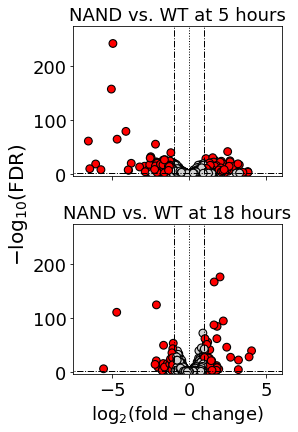

In [479]:
# volcano plots
fig,axs = plt.subplots(2,1,figsize=(4,6),sharex=True,sharey=True)
titles = ['NAND vs. WT at 5 hours', 'NAND vs. WT at 18 hours']
cnt = 0
for comp,ax in zip(res_dict,axs.reshape(-1)):
    ax.set_title(titles[cnt],fontsize=18)
    these_colors = ['lightgray'] * len(res_dict[comp])
    for ii,elem in enumerate(res_dict[comp].padj<0.05):
        if elem == True and (np.abs(res_dict[comp].log2FoldChange)[ii] >= 1.0):
            these_colors[ii] = 'red'
    ax.scatter(res_dict[comp].log2FoldChange,-np.log10(res_dict[comp].padj),s=60,c=these_colors,edgecolors='k',
              linewidths=1.1)
    ax.hlines(-np.log10(0.05),-8,8,color='k',linewidth=1,linestyles='dashdot')
    ax.vlines(1,0,275,color='k',linewidth=1,linestyles='dashdot')
    ax.vlines(-1,0,275,color='k',linewidth=1,linestyles='dashdot')
    ax.vlines(0,0,275,color='k',linewidth=1,linestyles='dotted')
    cnt += 1
axs[0].set_xlim(-7.5,6)
axs[0].set_ylim(-5,275)
# ax.set_xscale('log')
fig.text(0.27,0.0,r'$\log_2(\mathrm{fold-change})$',fontsize=18) # xlabel
fig.text(-0.02,0.37,r'$-\log_{10}(\mathrm{FDR})$',rotation='vertical',fontsize=20) # ylabel
plt.tight_layout()
# plt.savefig(figDir+'fig4/volcanoplots.pdf',dpi=300,transparent=True,bbox_inches='tight')  
plt.show()

In [480]:
# filter the dataframes to have only genes in genes_DE
DE_mask = [True]*13 # there are 13 circuit genes
for this_gene in all_genes_filter[13:]: # there are 13 circuit genes
    if this_gene in genes_DE: 
        DE_mask.append(True)
    else: 
        DE_mask.append(False)
        
df_cts_filter = df_cts_filter.loc[DE_mask].reset_index(drop=True)
df_tpm_filter = df_tpm_filter.loc[DE_mask].reset_index(drop=True)
df_tmm_filter = df_tmm_filter.loc[DE_mask].reset_index(drop=True)
df_getmm_filter = df_getmm_filter.loc[DE_mask].reset_index(drop=True)
all_genes_filter = [this_gene for ii, this_gene in enumerate(all_genes_filter) if DE_mask[ii]]

In [481]:
# filter the samples that don't have a timepoint pair due to low sequencing depth
unpaired_samples = []
for sample in df_cts_filter.columns: 
    if '5' in sample:
        if sample.replace('5','18') not in df_cts_filter.columns:
            print(sample,sample.replace('5','18'))
            unpaired_samples.append(sample)
    elif '18' in sample: 
        if sample.replace('18','5') not in df_cts_filter.columns:
            print(sample,sample.replace('18','5'))
            unpaired_samples.append(sample)

df_cts_filter = df_cts_filter.drop(columns=unpaired_samples).reset_index(drop=True)
df_tpm_filter = df_tpm_filter.drop(columns=unpaired_samples).reset_index(drop=True)
df_tmm_filter = df_tmm_filter.drop(columns=unpaired_samples).reset_index(drop=True)
df_getmm_filter = df_getmm_filter.drop(columns=unpaired_samples).reset_index(drop=True)

icar_003718R1 icar_00375R1
icar_013718R0 icar_01375R0
nand_103718R2 nand_10375R2
nand_103718R3 nand_10375R3
nand_113018R3 nand_11305R3
phlf_013018R1 phlf_01305R1
wt_013018R1 wt_01305R1


In [482]:
def get_rolling_stats(df):
    
    # get mean
    rolling_mean = {}
    rolling_cnt = {}
    for ii in range(df.shape[1]):
        this_observation = df.columns[ii]
        this_sample = this_observation.split('R')[0]
        if ii == 0: 
            rolling_mean[this_sample] = deepcopy(df[this_observation])
            rolling_cnt[this_sample] = 1
        else:
            prev_observation = df.columns[ii-1]
            prev_sample = prev_observation.split('R')[0]

        if ii!=0 and this_sample == prev_sample: 
            rolling_mean[this_sample] += deepcopy(df[this_observation])
            rolling_cnt[this_sample] += 1

        elif ii!=0 and this_sample != prev_sample:
            rolling_mean[this_sample] = deepcopy(df[this_observation])
            rolling_cnt[this_sample] = 1

    for key in rolling_mean: 
        rolling_mean[key] = rolling_mean[key] / rolling_cnt[key] # this is the mean that will be returned
        
    # get standard deviation
    rolling_std = {}
    for ii in range(df.shape[1]):
        this_observation = df.columns[ii]
        this_sample = this_observation.split('R')[0]
        if ii == 0: 
            rolling_std[this_sample] = (deepcopy(df[this_observation]) - rolling_mean[this_sample])**2
        else:
            prev_observation = df.columns[ii-1]
            prev_sample = prev_observation.split('R')[0]

        if ii!=0 and this_sample == prev_sample: 
            rolling_std[this_sample] += (deepcopy(df[this_observation]) - rolling_mean[this_sample])**2

        elif ii!=0 and this_sample != prev_sample:
            rolling_std[this_sample] = (deepcopy(df[this_observation]) - rolling_mean[this_sample])**2
    
    for key in rolling_std: 
        rolling_std[key] = np.sqrt(rolling_std[key]/rolling_cnt[key])
        
    return pd.DataFrame(rolling_mean),pd.DataFrame(rolling_std)

In [483]:
mu,sigma = get_rolling_stats(df_getmm_filter)

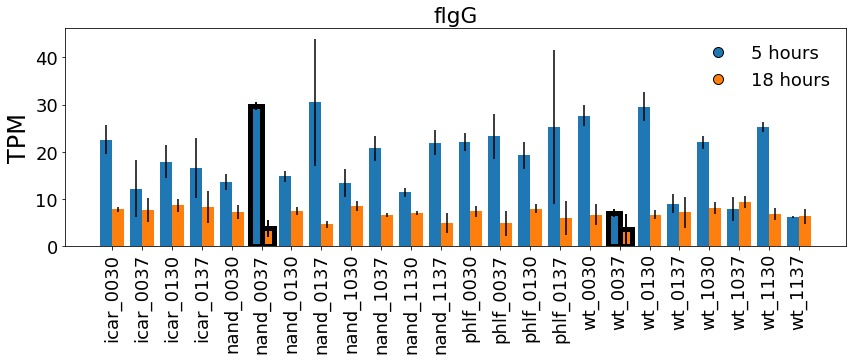

In [493]:
##### plot gene expression vs sample
fig,ax = plt.subplots(1,1,figsize=(14,4),sharex=True,sharey=True)
N = mu.shape[1]//2 # number of bars (counting both timepoints as a single bar as they will share x-pos)
ind = np.arange(N)
this_gene = all_genes_filter.index('flgG') # np.random.randint(0,len(all_genes_filter)) # gene to plot
width = 0.4 # width of bars # ('ychH', 'dps', 'rmf')
ax.set_title(all_genes_filter[this_gene])
ylab = 'TPM'
# gene_data = df_tmm_filter.loc[this_gene]; ylab = 'TMM'
# gene_data = df_getmm_filter.loc[this_gene]; ylab = 'GeTMM'
xpos_labels = [x.split('18')[0] for x in mu.iloc[:,list(range(0,mu.shape[1],2))].columns]

# 5 hour timepoint
ax.bar(ind,mu.iloc[:,list(range(1,mu.shape[1],2))].iloc[this_gene],width, 
       yerr=sigma.iloc[:,list(range(1,mu.shape[1],2))].iloc[this_gene],color='tab:blue') 
# 18 hour timepoint
ax.bar(ind+width,mu.iloc[:,list(range(0,mu.shape[1],2))].iloc[this_gene],width,
       yerr=sigma.iloc[:,list(range(0,mu.shape[1],2))].iloc[this_gene],color='tab:orange')

#     xpos_labels.append(mu.columns[ii].split('18')[0])

# 5 hour timepoint
ax.bar(5,mu.iloc[:,11].iloc[this_gene],width, 
       yerr=sigma.iloc[:,11].iloc[this_gene],color='tab:blue',
      linewidth=5,edgecolor='k') 
# 18 hour timepoint
ax.bar(5+width,mu.iloc[:,10].iloc[this_gene],width,
       yerr=sigma.iloc[:,10].iloc[this_gene],color='tab:orange',
      linewidth=5,edgecolor='k')

# 5 hour timepoint
ax.bar(17,mu.iloc[:,35].iloc[this_gene],width, 
       yerr=sigma.iloc[:,35].iloc[this_gene],color='tab:blue',
      linewidth=5,edgecolor='k') 
# 18 hour timepoint
ax.bar(17+width,mu.iloc[:,34].iloc[this_gene],width,
       yerr=sigma.iloc[:,34].iloc[this_gene],color='tab:orange',
      linewidth=5,edgecolor='k')
 

ax.plot([],[],'o',c='k',mfc='tab:blue',mew=1,ms=10,label='5 hours') 
ax.plot([],[],'o',c='k',mfc='tab:orange',mew=1,ms=10,label='18 hours')
ax.legend(frameon=False)
plt.xticks(ind + width / 2,xpos_labels,rotation=90)
ax.set_ylabel(ylab,fontsize=24)

plt.show()

In [28]:
# remove lowly expressed genes? 
keep_circuit_genes = [True]*13 # 13 circuit genes 
mean_cutoff = 200
high_mean_mask = keep_circuit_genes + list(np.mean(mu.iloc[13:],axis=1) > mean_cutoff)
my_df = deepcopy(df_getmm_filter).loc[high_mean_mask].reset_index(drop = True)
my_df_stand = ((my_df.T - my_df.T.mean())/my_df.T.std()).T
my_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if high_mean_mask[ii]]
print(len(my_genes))

320


In [32]:
res_dict['nand5_wt5']

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,aaeA,49.720233,-0.101735,0.203725,-0.499372,0.617518,0.728672
1,aaeB,41.003380,-0.184683,0.218668,-0.844584,0.398343,0.531865
2,aaeR,260.958619,-0.405900,0.153597,-2.642632,0.008226,0.020538
3,aaeX,34.349973,-0.340627,0.239958,-1.419528,0.155745,0.255822
4,aas,467.101602,0.033813,0.094266,0.358704,0.719817,0.809218
...,...,...,...,...,...,...,...
4064,insD1,506.254470,-0.107735,0.097730,-1.102375,0.270299,0.395576
4065,insQ,255.675965,-0.488443,0.148059,-3.298968,0.000970,0.002981
4066,insJ,9.502604,0.925584,0.494450,1.871945,0.061214,0.117544
4067,insK,8.885555,0.349553,0.424653,0.823150,0.410423,0.544597


#### Structured Koopman learning

In [29]:
def snapshots_from_df(df):

    strains = ['wt','icar','phlf','nand']
    tps = ['5','18']
    temps = ['30','37']
    inducers = ['00','10','01','11']

    # create a dictionary where you specify strain, temp, and inducers as keys to grab the snapshot matrices
    snapshot_dict = {}
    for strain in strains: 
        snapshot_dict[strain] = {}
        for temp in temps: 
            snapshot_dict[strain][temp] = {}
            for inducer in inducers: 
                snapshot_dict[strain][temp][inducer] = {} # keys are to be Yf and Yp
                # get substring of colname that identifies the group (so everything except rep number)
                yp_colname = strain + '_' + inducer + temp + tps[0]
                # get list of indices that correspond to this group (in short, grabbing inds for all replicates)
                yp_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yp_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yp'] = np.array(df.iloc[:,yp_col_inds])
                # do the same for the 18 hours timepoint i.e. Yf
                yf_colname = strain + '_' + inducer + temp + tps[1]
                yf_col_inds = [ii for ii, this_col in enumerate(list(df.columns)) if yf_colname in this_col]
                snapshot_dict[strain][temp][inducer]['Yf'] = np.array(df.iloc[:,yf_col_inds])
                
    return snapshot_dict

def get_unpaired_samples(df):
    # filter the samples that don't have a timepoint pair due to low sequencing depth
    unpaired_samples = []
    for sample in df.columns: 
        if '5' in sample:
            if sample.replace('5','18') not in df.columns:
#                 print(sample,sample.replace('5','18'))
                unpaired_samples.append(sample)
        elif '18' in sample: 
            if sample.replace('18','5') not in df.columns:
#                 print(sample,sample.replace('18','5'))
                unpaired_samples.append(sample)
    return unpaired_samples

def apply_normalizer(Yp,Yf):
    # normalize each datapoint individually
    transformer1 = Normalizer().fit(Yp.T)
    Yp_normed = transformer1.transform(Yp.T).T

    transformer2 = Normalizer().fit(Yf.T)
    Yf_normed = transformer2.transform(Yf.T).T
    return Yp_normed,Yf_normed

In [30]:
def calc_Koopman(Yf,Yp,flag=1,lambda_val=0.0,noise_scaler=1,verbose=True):
    ngenes = Yf.shape[0]
    ndatapts = Yf.shape[1]
    
    if flag == 1: # least-squares solution
        Yp_inv = np.linalg.pinv(Yp)
        K = np.dot(Yf,Yp_inv)
        print('The mean squared error is: ' + '{:0.3e}'.format(np.linalg.norm(K@Yp - Yf)**2 / ndatapts)) 
        # TO DO: Add SVD based DMD for modal decompostion (modes can be insightful)
        
    if flag == 2: # robust optimization approach
        solver_instance = cvxpy.SCS
        operator = Variable(shape=(ngenes,ngenes)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
        print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p=1) 
        else:
            lambda_val = lambda_val[:,np.newaxis]
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator + np.eye(ngenes),noise_scaler*Unoise),p='fro') # where exactly does this term come from?  

        norm2_fit_term = cvxpy.norm(Yf - cvxpy.matmul(operator,Yp),p=2)
        
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        K = operator.value
        
        print("[INFO]: CVXPY problem status: " + prob.status)
        print('MSE =  ' + '{:0.3e}'.format(np.linalg.norm(K@Yp - Yf)**2 / ndatapts)) 

    return K

def calc_input_Koopman(LHS,Up,flag=1,lambda_val=0.0,noise_scaler=1,verbose=True):
    ''' From Yf=AYp+BUp or Yf-AYp=BUp (A known) or Yf-(AYp + B_1U1 + ... )=B_JUJ (B_1 to B_J-1 known), we see 
        that the optimization can always be written as ||loss_lhs - operator*Up||_2 + ||G(operator)||_F.
    '''
    ngenes = LHS.shape[0]
    ndatapts = LHS.shape[1]
    ninputs = Up.shape[0]

    if flag == 1: # least-squares solution
        Up_inv = np.linalg.pinv(Up)
        Ki = np.dot(LHS,Up_inv)
        print('The mean squared error is: ' + '{:0.3e}'.format(np.linalg.norm(LHS - Ki@Up)**2 / ndatapts)) 
        # TO DO: Add SVD based DMD for modal decompostion (modes can be insightful)
        
    if flag == 2: # robust optimization approach
        solver_instance = cvxpy.SCS
        operator = Variable(shape=(ngenes,ninputs)) # Koopman matrix  K
        
        print("[INFO]: CVXPY Koopman operator variable: " + repr(operator.shape))
#         print("[INFO]: Shape of Yf and Yp: " + repr(Yf.shape) + ', ' + repr(Yp.shape) )
        
        if type(lambda_val) == float:
            reg_term = lambda_val * cvxpy.norm(operator,p=1) 
        else:
            lambda_val = lambda_val[:,np.newaxis]
            Unoise = np.tile(lambda_val,ndatapts)
            reg_term = cvxpy.norm(cvxpy.matmul(operator,noise_scaler*Unoise),p='fro') # where exactly does this term come from? 

        norm2_fit_term = cvxpy.norm(LHS - cvxpy.matmul(operator,Up),p=2) 
        objective = Minimize(norm2_fit_term + reg_term)
        constraints = []
        prob = Problem(objective,constraints)
        result = prob.solve(verbose=verbose,solver=solver_instance,max_iters=int(1e6))
        Ki = operator.value

        print("[INFO]: CVXPY problem status: " + prob.status)
        print('MSE =  ' + '{:0.3e}'.format(np.linalg.norm(LHS - Ki@Up)**2 / ndatapts)) 

    return Ki

In [69]:
def koopman_heatmap(thisK,figsize,xlabels,ylabels,shrink,savefig=False,savedir=''):
    fig = plt.figure(figsize=figsize)
    hm = sns.heatmap(thisK,linewidths=1.0,cmap=my_cmap,xticklabels=xlabels,yticklabels=ylabels,
                linecolor='white',square=True,annot=False,annot_kws={"size":11},fmt='2.1f',
                     cbar_kws={'shrink':shrink},center=0)
    if thisK.shape[1] == 1: 
        plt.xticks(fontsize=20,rotation='horizontal');
    else: 
        plt.xticks(fontsize=20,rotation='vertical');
    plt.yticks(fontsize=18,rotation='horizontal')
    plt.axhline(y=0, color='k',linewidth=3)
    plt.axhline(y=thisK.shape[0], color='k',linewidth=3)
    plt.axvline(x=0, color='k',linewidth=3)
    plt.axvline(x=thisK.shape[1], color='k',linewidth=3)
    cax = fig.axes[-1]
    cax.set_frame_on(True)
    for spine in cax.spines.values():
        spine.set(visible=True, lw=1, edgecolor='k')
    plt.tight_layout()
    if savefig:
        plt.savefig(savedir,dpi=300,bbox_inches='tight',transparent=True)
    plt.show()

- Start with lac and ara analysis from BioCAS paper

In [31]:
# load relevant dataframes
df_tpm_filter = pd.read_csv('data/TPM_matrix_NAND.csv')
unpaired_samples = get_unpaired_samples(df_tpm_filter)
all_genes_filter =  df_tpm_filter['gene']
df_tpm_filter = df_tpm_filter.iloc[:,1:]
df_tpm_filter = df_tpm_filter.drop(columns=unpaired_samples).reset_index(drop=True)
# all snapshots
snapshot_dict = snapshots_from_df(df_tpm_filter)

In [121]:
# get genes of interest
lac_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
ara_inds = [ii for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
lac_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'lac' in this_gene]
ara_genes = [this_gene for ii,this_gene in enumerate(all_genes_filter) if 'ara' in this_gene]
print(ara_genes+lac_genes)
my_genes = ara_genes + lac_genes
my_inds = ara_inds + lac_inds
circuit_genes = list(all_genes_filter[:13])

['araA', 'araB', 'araC', 'araD', 'araE', 'araF', 'araG', 'araH', 'araJ', 'lacA', 'lacI', 'lacY', 'lacZ']


##### Wild type dynamics

In [286]:
# Wild type snapshots
Yp = snapshot_dict['wt']['37']['00']['Yp']
Yf = snapshot_dict['wt']['37']['00']['Yf']

# normalize each snapshot to have unit norm. dynamics are preserved with this transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# subset to keep only the desired genes
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: Shape of Yf and Yp: (13, 4), (13, 4)
[INFO]: CVXPY problem status: optimal
MSE =  1.889e-27


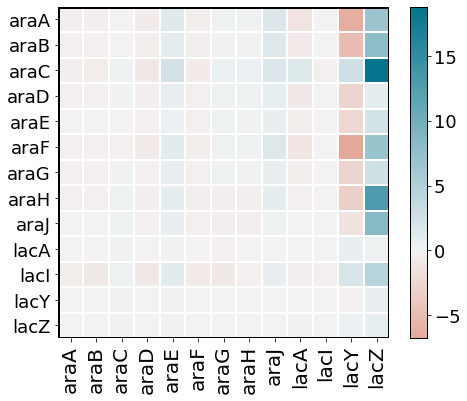

In [287]:
# compute the noise (of the noise), where was this motivated from?
lambda_val_vec_p = np.expand_dims(np.std(Yp_normed,axis=1),axis=1)
lambda_val_vec_f = np.expand_dims(np.std(Yf_normed,axis=1),axis=1)
lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)

K = calc_Koopman(Yf_normed,Yp_normed,flag=2,lambda_val=lambda_val_vec,noise_scaler=1,verbose=False)

######## Visualize host-interactions as heatmap ############
SAVEFIG = False
SAVEDIR = figDir+'fig1/Khost1137_ara-lac.pdf'
FIGSIZE = (7,6.5)
XLAB, YLAB = my_genes,my_genes
CBARSHRINK = 0.84
koopman_heatmap(K,FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)

##### Arabinose response, Input-Koopman matrix
- Treating arabinose as a step input

In [288]:
# get WT + arabinose snapshots
Yp = snapshot_dict['wt']['37']['10']['Yp']
Yf = snapshot_dict['wt']['37']['10']['Yf']

# normalize each snapshot to have unit norm. dynamics are preserved with this transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# subset to keep only the desired genes
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

Uara = (Yp_normed.max() - Yp_normed.min() )/2*np.ones((1,Yp_normed.shape[1])) # the step input magnitude should be on the scale as normalized data

In [289]:
# compute the noise in only the input data, since we already have a model of the host genes including noise
lambda_val_vec = np.std(Uara,axis=1)

LHS = Yf_normed - K@Yp_normed
Kara = calc_input_Koopman(LHS,Uara,flag=2,lambda_val=lambda_val_vec,verbose=False)

[INFO]: CVXPY Koopman operator variable: (13, 1)
[INFO]: CVXPY problem status: optimal
MSE =  1.931e-04


##### IPTG response, Input-Koopman matrix
- Treating IPTG as a step input

In [290]:
# get WT + IPTG snapshots
Yp = snapshot_dict['wt']['37']['01']['Yp']
Yf = snapshot_dict['wt']['37']['01']['Yf']

# normalize each snapshot to have unit norm. dynamics are preserved with this transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# subset to keep only the desired genes
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

Uiptg = (Yp_normed.max() - Yp_normed.min() )/2*np.ones((1,Yp_normed.shape[1])) # the step input magnitude should be on the scale as normalized data

In [291]:
# compute the noise in only the input data, since we already have a model of the host genes including noise
lambda_val_vec = np.std(Uiptg,axis=1)

LHS = Yf_normed - K@Yp_normed
Kiptg = calc_input_Koopman(LHS,Uiptg,flag=2,lambda_val=0.0+lambda_val_vec,verbose=False)

[INFO]: CVXPY Koopman operator variable: (13, 1)
[INFO]: CVXPY problem status: optimal
MSE =  9.384e-03


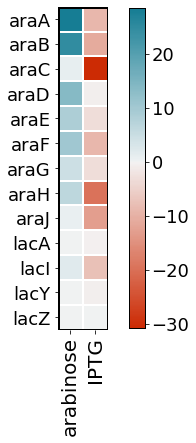

In [292]:
####################################################
SAVEFIG = False
SAVEDIR = figDir+'fig1/Kinducers37_ara-lac.pdf'
FIGSIZE = (6.5,6.5)
XLAB,YLAB = ['arabinose','IPTG'], my_genes
CBARSHRINK = 0.99
koopman_heatmap(np.hstack((Kara,Kiptg)),FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)

##### PhlF Gate + arabinose response

In [293]:
# get PhlF_Gate + arabinose snapshots
# recall there was a metadata mixup and so the key for (phlf only) arabinose, no iptg is [01]
Yp = snapshot_dict['phlf']['37']['01']['Yp']
Yf = snapshot_dict['phlf']['37']['01']['Yf']

# normalize each snapshot to have unit norm. dynamics are preserved with this transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# subset to keep only the desired genes
Uphlf = Yp_normed[:13,]
Uphlf_f = Yf_normed[:13,]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

In [294]:
# compute the noise in only the input data, since we already have a model of the host genes including noise
# compute the noise (of the noise), where was this motivated from?
lambda_val_vec_p = np.expand_dims(np.std(Uphlf,axis=1),axis=1)
lambda_val_vec_f = np.expand_dims(np.std(Uphlf_f,axis=1),axis=1)
lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)
# lambda_val_vec = np.std(Uphlf,axis=1)

if Yp_normed.shape[1] != Uara.shape[1]:
    print('Number of samples in Yp is ',Yp.shape[1])
    print('Number of samples in Uara is ', Uara.shape[1])
    print('Shape mismatch, need to correct. If solver runs, you have already corrected')

LHS = Yf_normed - K@Yp_normed - Kara@Uara[:,:-1]
Kphlf = calc_input_Koopman(LHS,Uphlf,flag=2,lambda_val=lambda_val_vec,noise_scaler=1,verbose=True)

Number of samples in Yp is  3
Number of samples in Uara is  4
Shape mismatch, need to correct. If solver runs, you have already corrected
[INFO]: CVXPY Koopman operator variable: (13, 13)
WARN: A->p (column pointers) not strictly increasing, column 106 empty
WARN: A->p (column pointers) not strictly increasing, column 107 empty
WARN: A->p (column pointers) not strictly increasing, column 108 empty
WARN: A->p (column pointers) not strictly increasing, column 109 empty
WARN: A->p (column pointers) not strictly increasing, column 110 empty
WARN: A->p (column pointers) not strictly increasing, column 111 empty
WARN: A->p (column pointers) not strictly increasing, column 112 empty
WARN: A->p (column pointers) not strictly increasing, column 113 empty
WARN: A->p (column pointers) not strictly increasing, column 114 empty
WARN: A->p (column pointers) not strictly increasing, column 115 empty
WARN: A->p (column pointers) not strictly increasing, column 116 empty
WARN: A->p (column pointers) no

##### IcaR Gate + IPTG response

In [295]:
# get IcaR Gate + arabinose snapshots
# recall there was a metadata mixup and so the key for (phlf only) arabinose, no iptg is [01]
Yp = snapshot_dict['icar']['37']['01']['Yp']
Yf = snapshot_dict['icar']['37']['01']['Yf']

# normalize each snapshot to have unit norm. dynamics are preserved with this transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# subset to keep only the desired genes
Uicar = Yp_normed[:13,]
Uicar_f = Yf_normed[:13,]
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

In [296]:
# compute the noise in only the input data, since we already have a model of the host genes including noise
# compute the noise (of the noise), where was this motivated from?
lambda_val_vec_p = np.expand_dims(np.std(Uicar,axis=1),axis=1)
lambda_val_vec_f = np.expand_dims(np.std(Uicar_f,axis=1),axis=1)
lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)
# lambda_val_vec = np.std(Uicar,axis=1)

if Yp_normed.shape[1] != Uiptg.shape[1]:
    print('Number of samples in Yp is ',Yp.shape[1])
    print('Number of samples in Uiptg is ', Uiptg.shape[1])
    print('Shape mismatch, need to correct. If solver runs, you have already corrected')

LHS = Yf_normed - K@Yp_normed - Kiptg@Uiptg[:,:-1] # the subsetting on U is due to sample number mismatch (some reps needed to be removed because of poor sequencing depth)
Kicar = calc_input_Koopman(LHS,Uicar,flag=2,lambda_val=lambda_val_vec,noise_scaler=1,verbose=True)

Number of samples in Yp is  3
Number of samples in Uiptg is  4
Shape mismatch, need to correct. If solver runs, you have already corrected
[INFO]: CVXPY Koopman operator variable: (13, 13)
WARN: A->p (column pointers) not strictly increasing, column 119 empty
WARN: A->p (column pointers) not strictly increasing, column 120 empty
WARN: A->p (column pointers) not strictly increasing, column 121 empty
WARN: A->p (column pointers) not strictly increasing, column 122 empty
WARN: A->p (column pointers) not strictly increasing, column 123 empty
WARN: A->p (column pointers) not strictly increasing, column 124 empty
WARN: A->p (column pointers) not strictly increasing, column 125 empty
WARN: A->p (column pointers) not strictly increasing, column 126 empty
WARN: A->p (column pointers) not strictly increasing, column 127 empty
WARN: A->p (column pointers) not strictly increasing, column 128 empty
WARN: A->p (column pointers) not strictly increasing, column 129 empty
WARN: A->p (column pointers) n

##### NAND Circuit + ara + IPTG + PhlF + IcaR response

In [297]:
# get IcaR Gate + arabinose snapshots
# recall there was a metadata mixup and so the key for (phlf only) arabinose, no iptg is [01]
Yp = snapshot_dict['nand']['37']['11']['Yp']
Yf = snapshot_dict['nand']['37']['11']['Yf']

# normalize each snapshot to have unit norm dynamics are preserved with this transformation
Yp_normed, Yf_normed = apply_normalizer(Yp,Yf)
# subset to keep only the desired genes
Unand = Yp_normed[:13,]
Unand_f = Yf_normed[:13,]
# let's see what happens if icar did not have zero expression in the nand circuit
# Unand[8,:] = np.random.normal(0.001,0.0001,size=Unand.shape[1])
# Unand_f[8,:] = np.random.normal(0.001,0.0001,size=Unand.shape[1])
Yp_normed, Yf_normed = Yp_normed[my_inds], Yf_normed[my_inds]

In [298]:
# compute the noise in only the input data, since we already have a model of the host genes including noise
# compute the noise (of the noise), where was this motivated from?
lambda_val_vec_p = np.expand_dims(np.std(Unand,axis=1),axis=1)
lambda_val_vec_f = np.expand_dims(np.std(Unand_f,axis=1),axis=1)
lambda_val_vec = np.std(np.hstack( (lambda_val_vec_p,lambda_val_vec_f)),axis=1)


# Must have same number of samples in all datasets (Unand, Yp, Yf, Uara, Uiptg, Uphlf, Uicar)
print(Unand.shape[1], Yp.shape[1], Yf.shape[1], Uara.shape[1], Uiptg.shape[1], Uphlf.shape[1], Uicar.shape[1])
keep_reps = [0,1,2,3]

LHS = Yf_normed[:,keep_reps] - K@Yp_normed[:,keep_reps] - Kiptg@Uiptg[:,keep_reps] - Kara@Uara[:,keep_reps] - \
        Kphlf@Unand[:,keep_reps] - Kicar@Unand[:,keep_reps]
        
Knand = calc_input_Koopman(LHS,Unand[:,keep_reps],flag=2,lambda_val=lambda_val_vec,noise_scaler=1.0,verbose=False)

4 4 4 4 4 3 3
[INFO]: CVXPY Koopman operator variable: (13, 13)
[INFO]: CVXPY problem status: optimal
MSE =  5.682e-21


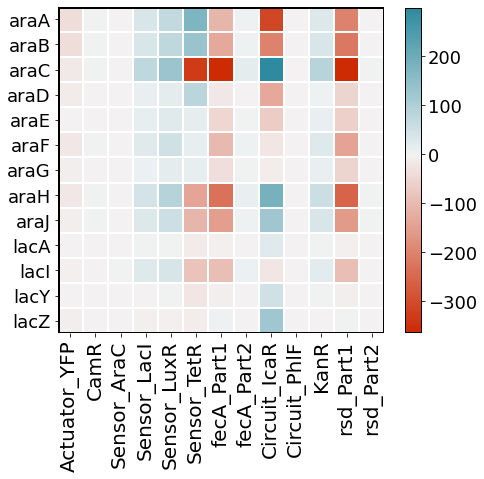

In [299]:
######## Visualize host-interactions as heatmap ############
SAVEFIG = False
SAVEDIR = figDir+'fig1/Knand1137_ara-lac.pdf'
FIGSIZE = (7.1,7.1)
XLAB, YLAB = circuit_genes,my_genes
CBARSHRINK = 0.88
koopman_heatmap(Knand,FIGSIZE,XLAB,YLAB,CBARSHRINK,savefig=SAVEFIG,savedir=SAVEDIR)

In [ ]:
# visualize dynamics
Y_mean = np.hstack((np.mean(Yp_normed,axis=1)[:,np.newaxis],np.mean(Yf_normed,axis=1)[:,np.newaxis]))
Y_std = np.hstack((np.std(Yp_normed,axis=1)[:,np.newaxis],np.std(Yf_normed,axis=1)[:,np.newaxis]))
xvals = [5.0,18.0]

plt.figure(figsize=(3,7))
# for ii in range(len(Y_mean)):
#     plt.plot(xvals,Y_mean[ii])
#     plt.fill_between(xvals,Y_mean[ii]-Y_std[ii],Y_mean[ii]+Y_std[ii],alpha=0.2)
    
# plt.xticks([5,18])
sns.heatmap(Y_mean,xticklabels=['5hr','18hr'],yticklabels=my_genes,cmap='Greens',linewidths=0.005,linecolor='k',
            square=False,annot=True,annot_kws={"size":11},fmt='0.5f',cbar_kws={'shrink':0.9})

plt.show()

In [ ]:
# visualize dynamics
Y_mean = np.hstack((np.mean(Unand,axis=1)[:,np.newaxis],np.mean(Unand_f,axis=1)[:,np.newaxis]))
Y_std = np.hstack((np.std(Unand,axis=1)[:,np.newaxis],np.std(Unand_f,axis=1)[:,np.newaxis]))
xvals = [5.0,18.0]

plt.figure(figsize=(3,7))
# for ii in range(len(Y_mean)):
#     plt.plot(xvals,Y_mean[ii])
#     plt.fill_between(xvals,Y_mean[ii]-Y_std[ii],Y_mean[ii]+Y_std[ii],alpha=0.2)
    
# plt.xticks([5,18])
sns.heatmap(Y_mean,xticklabels=['5hr','18hr'],yticklabels=list(all_genes_filter[:13]),cmap='Greens',linewidths=0.005,linecolor='k',
            square=False,annot=True,annot_kws={"size":11},fmt='0.5f',cbar_kws={'shrink':0.9})

plt.show()

In [ ]:
Ynand11.shape

#### Structured reconstruction visualization

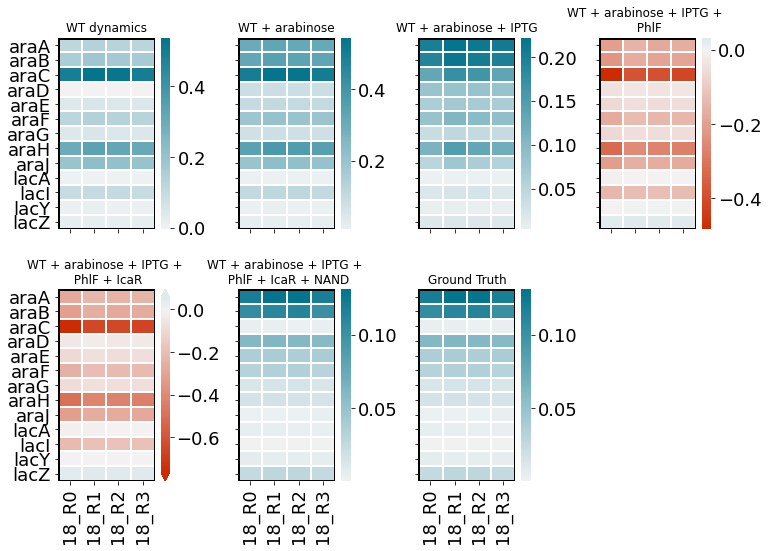

In [307]:
fig,axs = plt.subplots(2,4,figsize=(11,8),sharex=True,sharey=True)

fig.delaxes(axs[1,-1])
xlabels = ['18_R0','18_R1','18_R2','18_R3']
axs[0,0].set_title('WT dynamics',fontsize=12)
sns.heatmap(K@Yp_normed,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[0,0])
axs[0,1].set_title('WT + arabinose',fontsize=12)
sns.heatmap(K@Yp_normed+Kara@Uara,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[0,1])
axs[0,2].set_title('WT + arabinose + IPTG',fontsize=12)
sns.heatmap(K@Yp_normed+Kara@Uara+Kiptg@Uiptg,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[0,2])
axs[0,3].set_title('WT + arabinose + IPTG + \n PhlF',fontsize=12)
sns.heatmap(K@Yp_normed+Kara@Uara+Kiptg@Uiptg+Kphlf@Unand,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[0,3])
axs[1,0].set_title('WT + arabinose + IPTG + \n PhlF + IcaR',fontsize=12)
sns.heatmap(K@Yp_normed+Kara@Uara+Kiptg@Uiptg+Kphlf@Unand+Kicar@Unand,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[1,0])
axs[1,1].set_title('WT + arabinose + IPTG + \n PhlF + IcaR + NAND',fontsize=12)
sns.heatmap(K@Yp_normed+Kara@Uara+Kiptg@Uiptg+Kphlf@Unand+Kicar@Unand+Knand@Unand,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[1,1])
axs[1,2].set_title('Ground Truth',fontsize=12)
sns.heatmap(Yf_normed,cmap=my_cmap,center=0,linewidths=1,linecolor='white',square=False, \
           xticklabels=xlabels,yticklabels=my_genes,ax=axs[1,2])

for ax in axs.reshape(-1):
    ax.axhline(y=0, color='k',linewidth=3)
    ax.axhline(y=K.shape[0], color='k',linewidth=3)
    ax.axvline(x=0, color='k',linewidth=3)
    ax.axvline(x=Unand.shape[1], color='k',linewidth=3)
#     cax = fig.axes[-1]
#     cax.set_frame_on(True)
#     for spine in cax.spines.values():
#         spine.set(visible=True, lw=1, edgecolor='k')
plt.tight_layout()
# plt.savefig(figDir+'structured_reconstruction_visualization.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()


In [316]:
fig.axes

[<AxesSubplot:title={'center':'WT dynamics'}>,
 <AxesSubplot:title={'center':'WT + arabinose'}>,
 <AxesSubplot:title={'center':'WT + arabinose + IPTG'}>,
 <AxesSubplot:title={'center':'WT + arabinose + IPTG + \n PhlF'}>,
 <AxesSubplot:title={'center':'WT + arabinose + IPTG + \n PhlF + IcaR'}>,
 <AxesSubplot:title={'center':'WT + arabinose + IPTG + \n PhlF + IcaR + NAND'}>,
 <AxesSubplot:title={'center':'Ground Truth'}>,
 <AxesSubplot:label='<colorbar>'>,
 <AxesSubplot:label='<colorbar>'>,
 <AxesSubplot:label='<colorbar>'>,
 <AxesSubplot:label='<colorbar>'>,
 <AxesSubplot:label='<colorbar>'>,
 <AxesSubplot:label='<colorbar>'>,
 <AxesSubplot:label='<colorbar>'>]

In [ ]:
snapshot_dict = snapshots_from_df(df_tpm_filter)

In [ ]:
Yp = snapshot_dict['wt']['37']['00']['Yp']
Yf = snapshot_dict['wt']['37']['00']['Yf']

In [ ]:
Yp_normed,Yf_normed = apply_normalizer(Yp,Yf)
Yp_normed,Yf_normed = Yp_normed[13:],Yf_normed[13:]

In [ ]:
np.linalg.norm(ss[0]@Yp_normed - Yf_normed,ord='fro')**2/Yf_normed.shape[1]

In [ ]:
ss = pickle.load(open('data/x1_NAND.pkl','rb'))

In [ ]:
######## Visualize host-interactions as heatmap ############
fig = plt.figure(figsize=(20,20))
hm = sns.heatmap(ss[5],cmap=my_cmap,square=False,annot=False,annot_kws={"size":11},fmt='2.1f',
                 cbar_kws={'shrink':0.7,'extend':'both'},center=0)
plt.xticks(fontsize=20,rotation='vertical'); plt.yticks(fontsize=18,rotation='horizontal')
plt.tight_layout()
# plt.savefig(figDir+'fig1/Khost1037_ara-lac.pdf',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

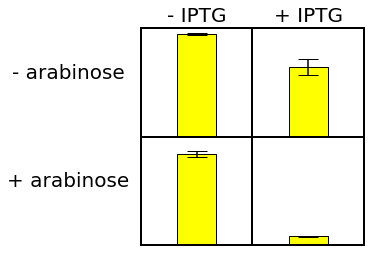

In [285]:
fig,ax = plt.subplots(2,2,figsize=(4,4),sharex=True,sharey=True)

Yp = snapshot_dict['nand']['37']['00']['Yp']
Yf = snapshot_dict['nand']['37']['00']['Yf']
ax[0,0].bar(0,Yp[0].mean(),yerr=Yp[0].std(),width=0.5,color='yellow',capsize=10,edgecolor='k')
ax[0,0].bar(0.25,0)
ax[0,0].bar(-0.25,0)

Yp = snapshot_dict['nand']['37']['01']['Yp']
Yf = snapshot_dict['nand']['37']['01']['Yf']
ax[0,1].bar(0,Yp[0].mean(),yerr=Yp[0].std(),width=0.5,color='yellow',capsize=10,edgecolor='k')
ax[0,1].bar(0.25,0)
ax[0,1].bar(-0.25,0)

Yp = snapshot_dict['nand']['37']['10']['Yp']
Yf = snapshot_dict['nand']['37']['10']['Yf']
ax[1,0].bar(0,Yp[0].mean(),yerr=Yp[0].std(),width=0.5,color='yellow',capsize=10,edgecolor='k')
ax[1,0].bar(0.25,0)
ax[1,0].bar(-0.25,0)

Yp = snapshot_dict['nand']['37']['11']['Yp']
Yf = snapshot_dict['nand']['37']['11']['Yf']
ax[1,1].bar(0,20*Yp[0].mean(),yerr=Yp[0].std(),width=0.5,color='yellow',capsize=10,edgecolor='k')
ax[1,1].bar(0.25,0)
ax[1,1].bar(-0.25,0)

plt.subplots_adjust(hspace=0,wspace=0)
plt.setp(ax, xticks=[], yticks=[])
for this_ax in ax.reshape(-1):
    for side in this_ax.spines.keys():
        this_ax.spines[side].set_linewidth(2)
        
ax[0,0].set_ylabel('- arabinose',fontsize=20,rotation='horizontal')
ax[0,0].yaxis.set_label_coords(-0.65, 0.5)
ax[1,0].set_ylabel('+ arabinose',fontsize=20,rotation='horizontal')
ax[1,0].yaxis.set_label_coords(-0.65, 0.5)
ax[0,0].set_title('- IPTG',fontsize=20)
ax[0,1].set_title('+ IPTG',fontsize=20)
    
# plt.savefig(figDir+'NAND_truth_table.pdf',dpi=300,transparent=True,bbox_inches='tight')
    
plt.show()

#### Load results from pickle (run_log.csv for run info)

In [111]:
ss37 = pickle.load(open('data/x7_NAND.pkl','rb'))
ss30 = pickle.load(open('data/x8_NAND.pkl','rb'))

In [144]:
total_impact_37 = [np.linalg.norm(thisK,ord='fro')/thisK.size for thisK in ss37[0:6]]
total_impact_30 = [np.linalg.norm(thisK,ord='fro')/thisK.size for thisK in ss30[0:6]]

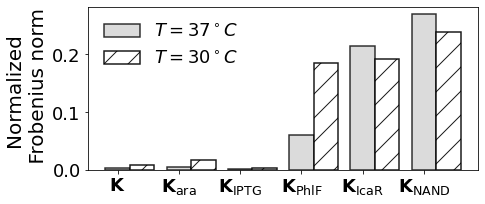

In [247]:
width=0.4
xlab = [r'$\mathbf{K}$',r'$\mathbf{K}_{\mathrm{ara}}$',r'$\mathbf{K}_{\mathrm{IPTG}}$',
        r'$\mathbf{K}_{\mathrm{PhlF}}$',r'$\mathbf{K}_{\mathrm{IcaR}}$',r'$\mathbf{K}_{\mathrm{NAND}}$']
plt.figure(figsize=(7,3))
plt.bar(range(6),total_impact_37,width=width,linewidth=1.5,color='lightgray',edgecolor='k',
        alpha=0.8,label=r'$T=37^\circ C$')
plt.bar([x+width for x in range(6)],total_impact_30,width=width,linewidth=1.5,color='white',
        edgecolor='k',alpha=0.9,hatch='/',label=r'$T=30^\circ C$')
plt.legend(frameon=False)
plt.xticks(range(6),xlab)
plt.ylabel('Normalized \n Frobenius norm',fontsize=20)
# plt.savefig(figDir+'fig4/total_impact.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


In [233]:
gene_wise_impact_37 = [np.linalg.norm(thisK,axis=0,ord=2) for thisK in ss37[0:6]]
gene_wise_impact_30 = [np.linalg.norm(thisK,axis=0,ord=2) for thisK in ss30[0:6]]

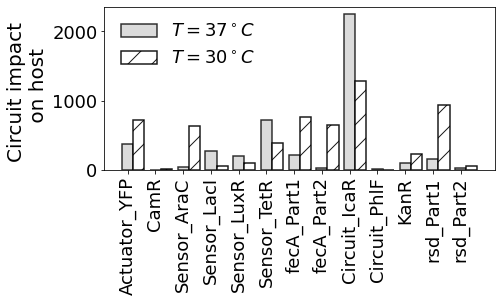

In [245]:
width=0.4
xlab = my_genes[:13]
plt.figure(figsize=(7,3))
plt.bar(range(len(xlab)),gene_wise_impact_37[-1],width=width,linewidth=1.5,color='lightgray',edgecolor='k',
        alpha=0.8,label=r'$T=37^\circ C$')
plt.bar([x+width for x in range(len(xlab))],gene_wise_impact_30[-1],width=width,linewidth=1.5,color='white',
        edgecolor='k',alpha=0.9,hatch='/',label=r'$T=30^\circ C$')
plt.legend(frameon=False)
plt.xticks(range(len(xlab)),xlab,rotation=90)
plt.ylabel('Circuit impact \n on host',fontsize=20)
# plt.savefig(figDir+'fig4/circuit_impact_on_host.pdf',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


In [248]:
impacted_genes_37 = [np.linalg.norm(thisK,axis=1,ord=2) for thisK in ss37[0:6]]
impacted_genes_30 = [np.linalg.norm(thisK,axis=1,ord=2) for thisK in ss30[0:6]]

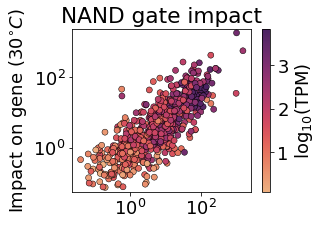

In [389]:
plt.figure(figsize=(4,3))
plt.title('NAND gate impact')
ax = sns.scatterplot(x=impacted_genes_37[-1],y=impacted_genes_30[-1],hue=np.log10(mu[13:]['nand_00375']+1),
                     edgecolor='k',legend=False,palette='flare')
# plt.xlabel(r'Impact on gene ($37^{\circ}C$)')
plt.ylabel(r'Impact on gene ($30^{\circ}C$)')
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')
norm = plt.Normalize(np.log10(mu[13:]['nand_00375']+1).min(), np.log10(mu[13:]['nand_00375']+1).max())
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
cb = ax.figure.colorbar(sm)
cb.set_label(r'$\log_{10}(\mathrm{TPM})$')
# plt.savefig(figDir+'fig4/NANDgateImpact.pdf',transparent=True,dpi=300,bbox_inches='tight')
plt.show()

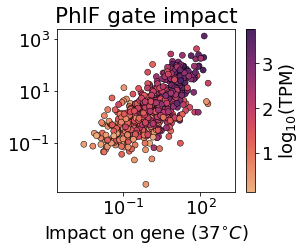

In [390]:
plt.figure(figsize=(4,3))
plt.title('PhlF gate impact')
ax = sns.scatterplot(x=impacted_genes_37[-3],y=impacted_genes_30[-3],hue=np.log10(mu[13:]['phlf_00375']+1),
                     edgecolor='k',legend=False,palette='flare')
plt.xlabel(r'Impact on gene ($37^{\circ}C$)')
# plt.ylabel(r'Impact on gene ($30^{\circ}C$)')
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')

norm = plt.Normalize(np.log10(mu[13:]['phlf_00375']+1).min(), np.log10(mu[13:]['phlf_00375']+1).max())
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
cb = ax.figure.colorbar(sm)
cb.set_label(r'$\log_{10}(\mathrm{TPM})$')
# plt.savefig(figDir+'fig4/PhlFgateImpact.pdf',transparent=True,dpi=300,bbox_inches='tight')

plt.show()

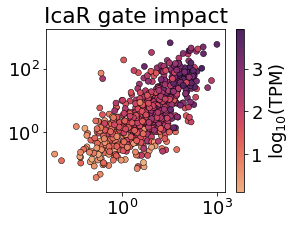

In [391]:
plt.figure(figsize=(4,3))
plt.title('IcaR gate impact')
ax = sns.scatterplot(x=impacted_genes_37[-2],y=impacted_genes_30[-2],hue=np.log10(mu[13:]['icar_00375']+1),
                     edgecolor='k',legend=False,palette='flare')
# plt.xlabel(r'Impact on gene ($37^{\circ}C$)')
# plt.ylabel(r'Impact on gene ($30^{\circ}C$)')
plt.xscale('log')
plt.yscale('log')
plt.axis('equal')

norm = plt.Normalize(np.log10(mu[13:]['icar_00375']+1).min(), np.log10(mu[13:]['icar_00375']+1).max())
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sm.set_array([])
# Remove the legend and add a colorbar
# ax.get_legend().remove()
cb = ax.figure.colorbar(sm)
cb.set_label(r'$\log_{10}(\mathrm{TPM})$')
# plt.savefig(figDir+'fig4/IcaRgateImpact.pdf',transparent=True,dpi=300,bbox_inches='tight')
plt.show()